In [1]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [96]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
Tue Jul 18 12:43:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   42C    P0    67W / 275W |      0MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM... 

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[19:33:54.081] INFO   CaloQVAE                                          Willkommen!
[19:33:54.082] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml')
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml')

2023-07-17 19:33:54,507 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[19:33:54.507] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [461]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [505]:
np.unique(HLF_1_pions.bin_edges)

array([  0,   8, 108, 208, 213, 363, 523, 533])

In [462]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/home/javier/miniconda3/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[17:43:14.406] INFO   data.dataManager                                  Loading Data
[17:43:17.998] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe06407bb20>: 79946 events, 625 batches
[17:43:17.999] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe06407b160>: 9993 events, 10 batches
[17:43:17.999] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe064317130>: 9994 events, 10 batches
[17:43:19.347] INFO   models.modelCreator                               Initialising Model Type GumBoltCaloCRBM
2023-07-18 17:43:19,349 d

Initializing NetworkV3


In [463]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[17:43:24.241] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 368])
[17:43:24.242] INFO   wandb                                             Watching
[17:43:24.245] INFO   engine.engineCaloV3                               Setting up engine Calo.
[17:43:24.246] INFO   engine.engine                                     Setting up default engine.


In [464]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[17:43:27.878] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe135acb6d0>: 79946 events, 625 batches
[17:43:27.879] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe135acb8b0>: 9993 events, 10 batches
[17:43:27.880] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe135acb490>: 9994 events, 10 batches


In [465]:
###LOAD MODEL

In [466]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [467]:
#Pions cond on Decoder
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-07-05/12-27-11/wandb/run-20230705_122715-uxyvraes/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth'
#Pions Noncond on Decoder
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-06-30/06-51-53/wandb/run-20230630_065158-qx3cmkt0/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-07/17-09-08/wandb/run-20230707_170909-vsslbz0h/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"


#Photons Noncond on Decoder
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-07-01/16-26-45/wandb/run-20230701_162650-eap4avzf/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'
#Photons cond dec
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-07-07/08-39-58/wandb/run-20230707_084003-a3wr6q10/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'
#Photons w/ classifier
# run_path = '/home/javier/Projects/CaloQVAE/outputs/2023-07-08/23-57-14/wandb/run-20230708_235715-u7yk2qyo/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'
# run_path = '/home/javier/Projects/CaloQVAE/outputs/2023-07-09/13-28-53/wandb/run-20230709_132854-ndjguffk/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'


# photonEn0
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-11/19-17-34/wandb/run-20230711_191735-ps7le1q8/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

# photonEn7
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-11/19-08-43/wandb/run-20230711_190844-hyruxtix/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

# pionEn0
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-11/18-35-00/wandb/run-20230711_183501-jeg84356/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

# pionEn7
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-11/18-34-47/wandb/run-20230711_183448-s2yyt3me/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

#pion1 w/o classifier
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-13/22-33-36/wandb/run-20230713_223337-jfhgxx4x/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

#pion1 w/ classifier
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-13/22-34-59/wandb/run-20230713_223500-pvuel0me/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

# sunny-durian
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-14/19-06-36/wandb/run-20230714_190637-q2eflqao/files/GumBoltCaloCRBM_atlas_default_best.pth"
modelname = 'sunny-durian'
datascaled = 'scaled'

# trim-thunder
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-14/19-27-06/wandb/run-20230714_192707-xnxel2of/files/GumBoltAtlasCRBMCNNV2_atlas_default_best.pth"
# modelname = 'trim-thunder'
# datascaled = 'scaled'

# hardy-valley
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-14/21-31-47/wandb/run-20230714_213148-3l3cjkxg/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# modelname = 'hardy-valley'
# datascaled = 'reduced'

# dazzling-lion
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-14/21-28-23/wandb/run-20230714_212824-6ienf984/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-14/21-28-23/wandb/run-20230714_212824-6ienf984/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'dazzling-lion'
# datascaled = 'reduced'

# misunderstood-waterfall
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-14/19-35-13/wandb/run-20230714_193514-gnozkzuu/files/GumBoltAtlasCRBMCNNV2_atlas_default_best.pth"
# modelname = 'misunderstood-waterfall'
# datascaled = 'scaled'

# logical-violet
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-14/18-45-42/wandb/run-20230714_184543-fmllcxb0/files/GumBoltCaloCRBM_atlas_default_best.pth"
# modelname = 'logical-violet'
# datascaled = 'scaled'

arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

GumBoltCaloCRBM
photonEn5
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
Loading weights for module =  sampler


In [468]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([1024, 368])


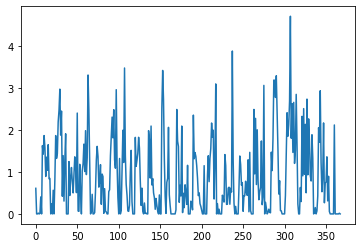

In [469]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[2,:])

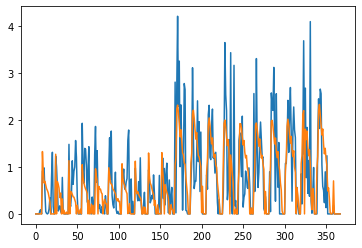

In [470]:
with torch.no_grad():
    fwd_output = engine.model((in_data, true_energy), True)
idx = 20
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:])

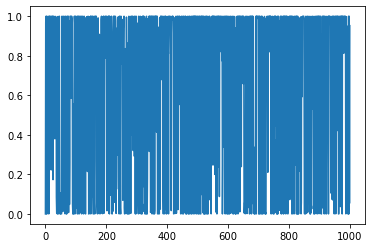

In [471]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    enIn = torch.cat((in_data, true_energy), dim=1)
    beta, post_logits, post_samples = engine.model.encoder(enIn)
    # beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

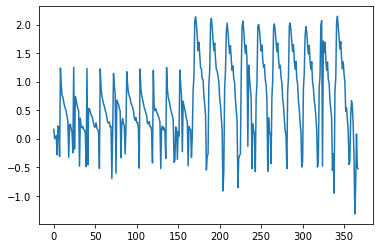

In [473]:
post_samples = torch.cat([post_samples, true_energy], dim=1)
output_hits, output_activations = engine.model.decoder(post_samples)
# output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


In [494]:
# for i in range(1,100):
#     print(368 % i, i, 368/i)

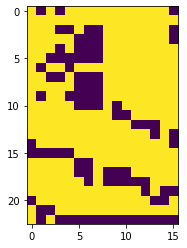

In [502]:
# engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu()
idx=5
plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(23,16))

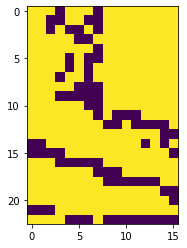

In [503]:
# plt.plot(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy())
# plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu())

# plt.scatter(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy(), engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu())
plt.imshow(engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu().reshape(23,16))


In [205]:
# engine._data_mgr.inv_transform(output_activations.detach().cpu().numpy())
# torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))

In [417]:
en_labels = []
xtarget_samples = []
xrecon_samples = []
xitarget_samples = []
xirecon_samples = []
labelstarget_samples = []
labelsrecon_samples = []
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    fwd_output = engine.model((in_data, true_energy), True)
    xVec = (fwd_output.output_activations.detach().exp() - 1)*0.04*true_energy
    
    xirecon_samples.append(fwd_output.output_activations.detach().cpu())
    # xrecon_samples.append( xVec.detach().cpu() )
    xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    # labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    
    xitarget_samples.append(in_data.detach().cpu())
    # xtarget_samples.append( xx[0][0].detach().cpu() )
    xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    # labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )
    
    en_labels.append(true_energy.detach().cpu())
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
# labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
xitarget_samples = torch.cat(xitarget_samples, dim=0)  
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xirecon_samples = torch.cat(xirecon_samples, dim=0) 
# labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
en_labels = torch.cat(en_labels, dim=0)

# lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
# l = torch.argmax(labelstarget_samples, dim=1).numpy()

In [128]:
# plt.hist(np.log(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, histtype='step')
# plt.hist(np.log(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, histtype='step', log=True)
# plt.show()

In [127]:
# plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=100, density=True)
# plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
# plt.show()

In [129]:
# #Sparsity
# for enIdx in en_labels.unique().numpy():
#     idxBool = (en_labels == enIdx).nonzero(as_tuple=True)[0]
#     xtargetTmp = xtarget_samples[idxBool,:]
#     xreconTmp = xrecon_samples[idxBool, :]
#     plt.hist(((xtargetTmp == 0).sum(dim=1)/368).numpy(), bins=50, density=True)
# #     plt.hist(((xreconTmp == 0).sum(dim=1)/368).numpy(), bins=50, density=True, alpha=0.9)
# plt.legend(list(en_labels.unique().numpy()))
# plt.xlabel("Sparsity Index")
# plt.ylabel("PDF")
# plt.title("Photons GT")
# plt.show()

In [130]:
# #Sparsity
# for enIdx in en_labels.unique().numpy():
#     idxBool = (en_labels == enIdx).nonzero(as_tuple=True)[0]
#     xtargetTmp = xtarget_samples[idxBool,:]
#     xreconTmp = xrecon_samples[idxBool, :]
#     # plt.hist(((xtargetTmp == 0).sum(dim=1)/368).numpy(), bins=50, density=True)
#     plt.hist(((xreconTmp == 0).sum(dim=1)/368).numpy(), bins=30, density=True, alpha=0.9)
# plt.legend(list(en_labels.unique().numpy()), bbox_to_anchor=(1.1, 1.05))
# plt.xlabel("Sparsity Index")
# plt.ylabel("PDF")
# plt.title("Pions Recon")
# plt.show()

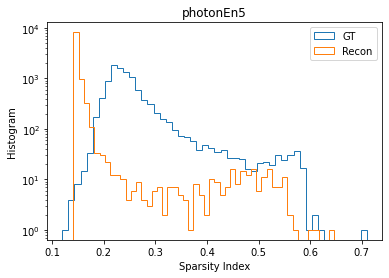

In [418]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/368).numpy(), bins=50, log=True, histtype='step')
plt.hist(((xrecon_samples == 0).sum(dim=1)/368).numpy(), bins=50, log=True, histtype='step')
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon"])
plt.title(f'{part}')
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

Layer  0 8  voxels


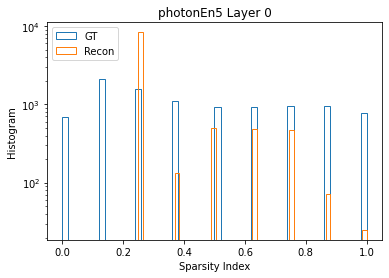

Layer  1 160  voxels


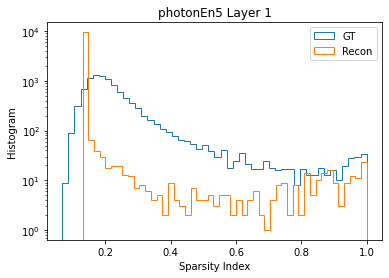

Layer  2 190  voxels


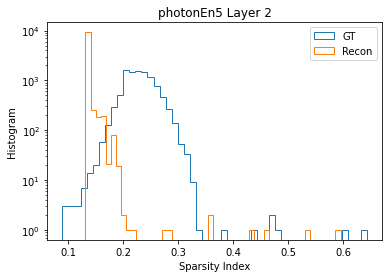

Layer  3 5  voxels


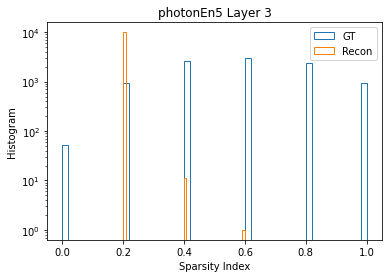

Layer  4 5  voxels


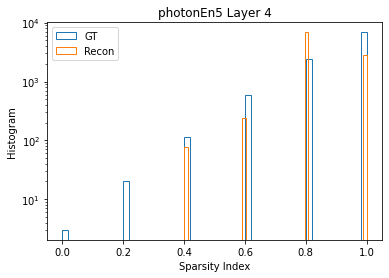

In [419]:
idxPrev = 0
# for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=50, log=True, histtype='step')
    plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=50, log=True, histtype='step')
    plt.xlabel("Sparsity Index")
    plt.ylabel("Histogram")
    plt.legend(["GT", "Recon"])
    plt.title(f'{part} Layer {i}')
    plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

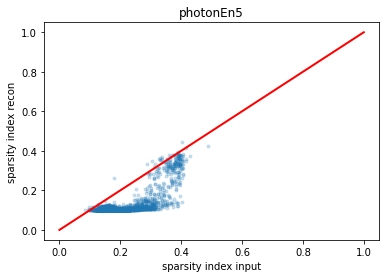

In [420]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/533).numpy(), ((xrecon_samples == 0).sum(dim=1)/533).numpy(),  marker='.', alpha=.2)
plt.plot([0,1],[0,1], c='red', lw=2)
plt.xlabel('sparsity index input')
plt.ylabel('sparsity index recon')
plt.title(f'{part}')
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [421]:
# (xtarget_samples[:,0:8] == 0).sum(dim=1)/8

Layer  0 8  voxels


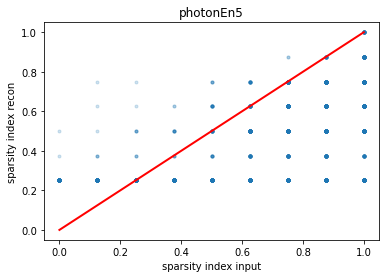

Layer  1 160  voxels


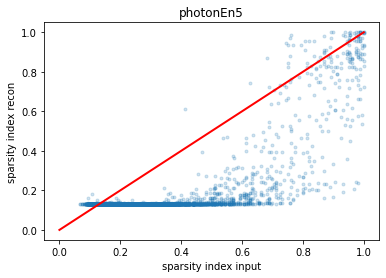

Layer  2 190  voxels


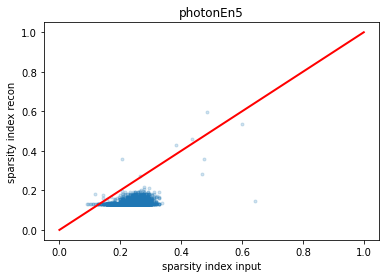

Layer  3 5  voxels


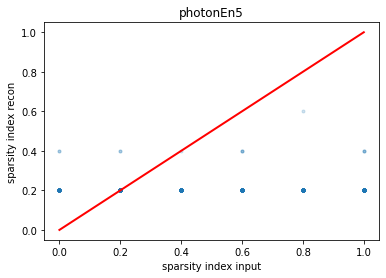

Layer  4 5  voxels


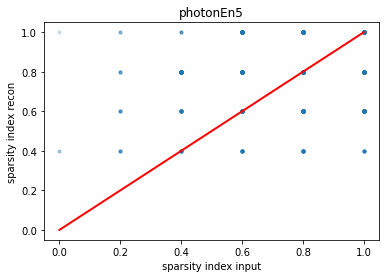

In [422]:
idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.scatter(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), marker='.', alpha=.2)
    plt.plot([0,1],[0,1], c='red', lw=2)
    plt.xlabel('sparsity index input')
    plt.ylabel('sparsity index recon')
    plt.title(f'{part}')
    plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

In [401]:
# xihat_samples.shape
np.unique(HLF_1_photons.bin_edges)

array([  0,   8, 168, 358, 363, 368])

In [61]:

lhatSamp.shape
labelshat_samples.shape
5*15*1024
xhat_samples.shape

torch.Size([76800, 368])

In [41]:
# model.generate_samples(num_samples=1024, true_energy=0)

In [42]:
# sample_data

In [430]:
xhat_samples = []
xihat_samples = []
# labelshat_samples = []
with torch.no_grad():
    for en in range(5,6):
        data_sampled = []
        for i in range(10):
            # sample_energies, sample_data = model.generate_samples(num_samples=1024, true_energy=en)
            sample_energies, sample_data = model.generate_samples(num_samples=1024, true_energy=8000)
            # data_sampled.append(sample_data.detach().cpu())
            data_sampled.append(torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy())))
        data_sampled = torch.cat(data_sampled, dim=0)
        # xhat_samples.append((data_sampled.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),en))
        xhat_samples.append(data_sampled)
        xihat_samples.append(data_sampled)
        # labelshat_samples.append(fwd_output.labels.detach().cpu())
xhat_samples = torch.cat(xhat_samples, dim=0)
xihat_samples = torch.cat(xihat_samples, dim=0)
# labelshat_samples = torch.cat(labelshat_samples, dim=0)

# lhatSamp = torch.argmax(nn.Sigmoid()(labelshat_samples), dim=1).numpy()

In [28]:
sam = []
for i in range(1):
    sample_energies, sample_data = model.generate_samples(num_samples=1000, true_energy=14)
    sam.append(sample_data.detach().cpu())
sam = torch.cat(sam, dim=0)

NameError: name 'sample_data_test' is not defined

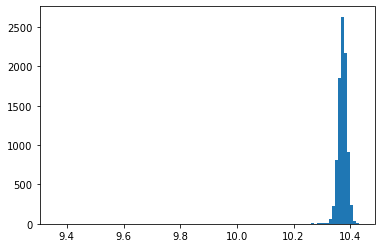

In [58]:
plt.hist(np.log(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=False)
# plt.hist(np.log(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.5)
# plt.hist(np.log(xhat_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.7)

sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),7)
plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("Log of energy per event")
plt.ylabel("PDF")
plt.legend(["GT", "Sample"])
plt.title("Photons")
plt.show()

In [25]:
# xhat = (sample_data.detach().exp() - 1)*0.04*256*np.power(2,1)
# # plt.hist(xhat.sum(dim=1).cpu().numpy(), bins=100, density=True)
# plt.hist(np.log(xhat.sum(dim=1).cpu().numpy() + 1e-10), bins=100, density=True)
# plt.show()

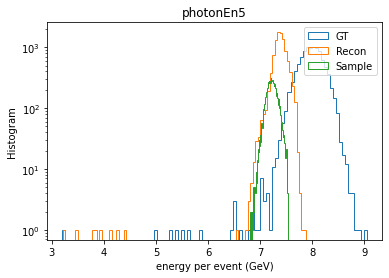

In [431]:
# plt.hist(np.log2(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, log=True, histtype='step')
# plt.hist(np.log2(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, log=True, histtype='step')
# plt.hist(np.log2(xhat_samples.sum(dim=1).numpy() + 1e-10), bins=100, log=True, histtype='step')
# plt.xlabel("Log2 of energy per event")

plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=100, log=True, histtype='step')
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=100, log=True, histtype='step')
plt.hist(xhat_samples.sum(dim=1).numpy()/1000, bins=100, log=True, histtype='step')
plt.xlabel("energy per event (GeV)")

# sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),0)
# plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample"])
plt.title(f'{part}')
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

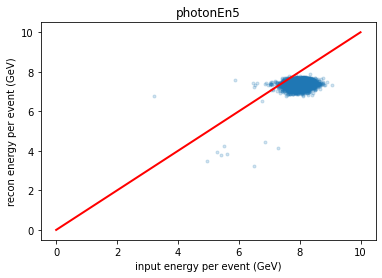

In [432]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.2)
plt.plot([0,10],[0,10], c='red', lw=2)

# sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),0)
# plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("input energy per event (GeV)")
plt.ylabel("recon energy per event (GeV)")
plt.title(f'{part}')
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [358]:
# plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.hist(xihat_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.xlabel("ξ per event")
# plt.ylabel("PDF")
# plt.legend(["GT", "Recon", "Sample"])
# plt.title("Pions")
# plt.show()

Layer  0 8  voxels


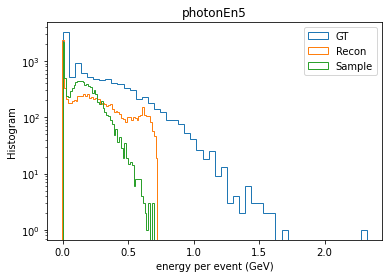

Layer  1 160  voxels


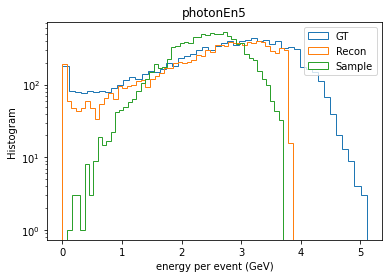

Layer  2 190  voxels


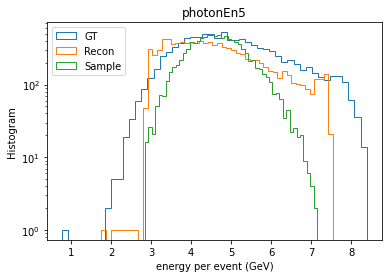

Layer  3 5  voxels


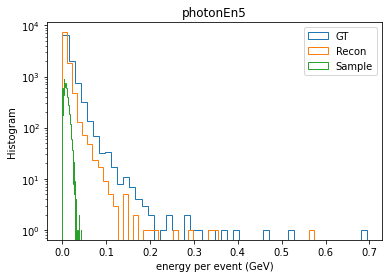

Layer  4 5  voxels


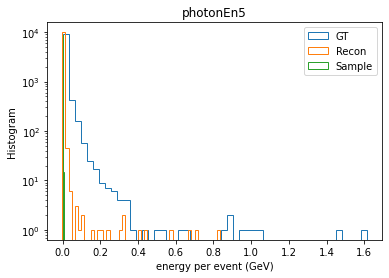

In [433]:
idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.hist(xhat_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.xlabel("energy per event (GeV)")
    plt.ylabel("Histogram")
    plt.legend(["GT", "Recon", "Sample"])
    plt.title(f'{part}')
    plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

Layer  0 8  voxels


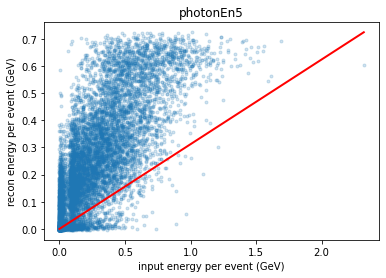

Layer  1 160  voxels


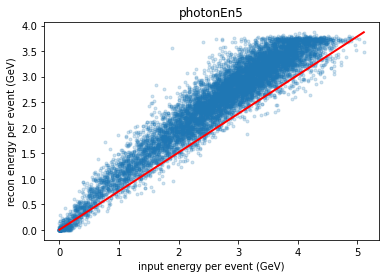

Layer  2 190  voxels


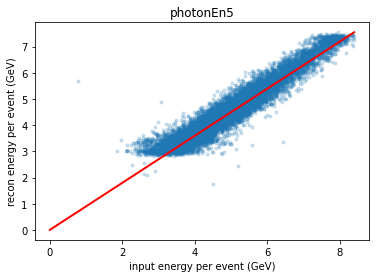

Layer  3 5  voxels


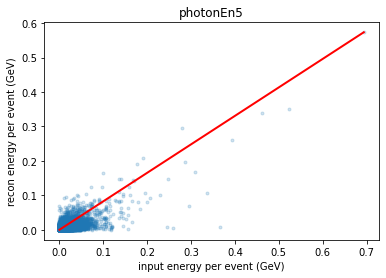

Layer  4 5  voxels


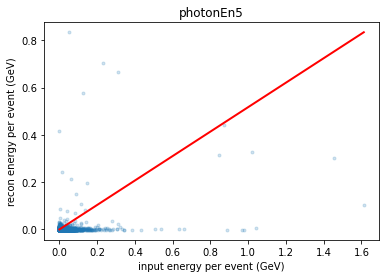

In [434]:
idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.scatter(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, marker='.', alpha=.2)
    plt.plot([0,xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000],[0,xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000], c='red', lw=2)
    
    plt.xlabel("input energy per event (GeV)")
    plt.ylabel("recon energy per event (GeV)")
    plt.title(f'{part}')
    plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

In [459]:
engine.model.encoder

EncoderUCNN(
  (_layers): ModuleList()
  (activation_fct): ReLU()
  (_networks): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Linear(in_features=368, out_features=576, bias=True)
        (1): Unflatten(dim=1, unflattened_size=(1, 24, 24))
        (2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
        (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): PReLU(num_parameters=16)
      )
      (1): Sequential(
        (0): Conv2d(17, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): PReLU(num_parameters=32)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (smoothing_dist_mod): GumbelMod(
    (activation_fct): Sigmoid()
  )
  (seq1): Sequential(
    (0): Linear(in_features=368, out_features=576, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(1, 24, 24))
    (2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(16, eps=1e-

In [460]:
model.decoder

DecoderCNN(
  (_layers): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(1000, 1, 1))
    (1): ConvTranspose2d(1000, 512, kernel_size=(4, 4), stride=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=512)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): PReLU(num_parameters=256)
    (7): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=128)
  )
  (_activation_fct): ReLU()
  (_layers2): Sequential(
    (0): ConvTranspose2d(128, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=32)
    (3): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(1, 1))
  

In [ ]:
# GT and Recon Comparison

In [55]:
sampDataAll, sampDataOutAll = np.array([]), np.array([])
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    fwd_output = engine.model((in_data, true_energy), True)
    
    sampDataAll = np.append(sampDataAll, np.sum(in_data.detach().cpu().numpy(), axis=1))
    sampDataOutAll = np.append(sampDataOutAll, np.sum(fwd_output.output_activations.detach().cpu().numpy(), axis=1))

In [61]:
binwidth = 1

plt.hist(sampDataAll, bins=range(int(np.floor(min(sampDataAll))), int(np.ceil(max(sampDataAll))) + binwidth, binwidth), log=True, density=True)
plt.hist(sampDataOutAll, bins=range(int(np.floor(min(sampDataOutAll))), int(np.ceil(max(sampDataOutAll))) + binwidth, binwidth), log=True, density=True, alpha = 0.5)
plt.show()

NameError: name 'sampDataAll' is not defined

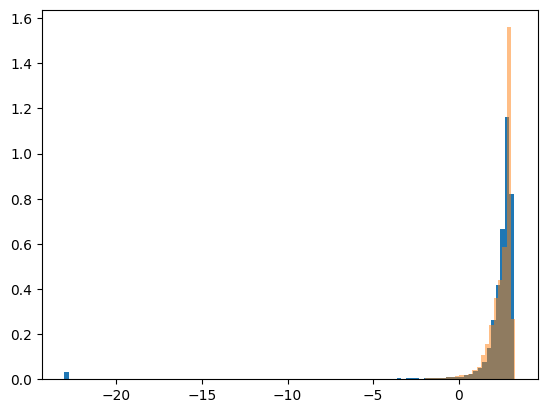

In [57]:
binwidth = 1
plt.hist(np.log(sampDataAll + 1e-10), bins=100, density=True)
plt.hist(np.log(sampDataOutAll + 1e-10), bins=100, density=True, alpha = 0.5)
plt.show()

In [33]:
# model

In [31]:
# model._hit_smoothing_dist_mod #(output_hits, beta, is_training)

In [89]:
seq1 = nn.Sequential(
                   # nn.Linear(self.num_input_nodes, 24*24),
                   # nn.Unflatten(1, (1,24, 24)),
    
                   nn.Conv2d(1, 16, 3, 1, 0),
                   nn.BatchNorm2d(16),
                   nn.PReLU(16, 0.02),
                )
sequential2 = nn.Sequential(
                   nn.Conv2d(17, 32, 3, 1, 0),
                   # nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(32, 0.02),
                   nn.BatchNorm2d(32),
                )

sequential3 = nn.Sequential(
                   nn.Conv2d(33, 64, 3, 1, 0),
                   nn.BatchNorm2d(64),
                   nn.PReLU(64, 0.02),
                )

sequential4 = nn.Sequential(
                   nn.Conv2d(65, 128, 3, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(128, 0.02),
                   nn.BatchNorm2d(128),
                   

                   nn.Conv2d(128, 256, 3, 1, 0),
                   nn.BatchNorm2d(256),
                   nn.PReLU(256, 0.02),
                   

                   nn.Conv2d(256, 512, 2, 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512, 0.02),
                   
    
                   nn.Conv2d(512, 1024, 2, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   nn.BatchNorm2d(1024),
                   nn.PReLU(1024, 0.02),

                    nn.Conv2d(1024, 1000, 2, 1, 0),
                   # nn.MaxPool2d(2,stride=2),
                   # nn.PReLU(self.n_latent_nodes, 0.02),
                   nn.Sigmoid(),
                   # nn.BatchNorm2d(self.n_latent_nodes),
    
                   nn.Flatten(),
                )


In [90]:
x = torch.rand(2,1,24,24)
x0 = torch.ones(2,1)*3
minEnergy = 3
x = seq1(x)
x = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item()).divide(minEnergy).log2()), 1)
x = sequential2(x)
x = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item()).divide(minEnergy).log2()), 1)
x = sequential3(x)
x = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item()).divide(minEnergy).log2()), 1)
x = sequential4(x)

x.shape



# tuple(torch.tensor(x.shape[-2:]).tolist())
# tuple([1,2])
# torch.tensor(x.shape[-2:-1]).item()

torch.Size([2, 1000])

In [ ]:
nn.Sequential(
                   nn.Linear(self.num_input_nodes, 24*24),
                   nn.Unflatten(1, (1,24, 24)),
    
                   nn.Conv2d(1, 16, 3, 1, 0),
                   nn.BatchNorm2d(64),
                   nn.PReLU(16, 0.02),
                )
        self.sequential2 = nn.Sequential(
                   nn.Conv2d(65, 128, 3, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(128, 0.02),
                   nn.BatchNorm2d(128),
                   

                   nn.Conv2d(128, 256, 3, 1, 0),
                   nn.BatchNorm2d(256),
                   nn.PReLU(256, 0.02),
                   

                   nn.Conv2d(256, 512, 2, 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512, 0.02),
                   
    
                   nn.Conv2d(512, 1024, 2, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   nn.BatchNorm2d(1024),
                   nn.PReLU(1024, 0.02),